1.Submit a Google Colab notebook containing your completed code and experimentation results.

2.Include comments and explanations in your code to help understand the implemented logic.

**Additional Notes:**
*   Ensure that the notebook runs successfully in Google Colab.
*   Document any issues encountered during experimentation and how you addressed them.

**Grading:**
*   Each task will be graded out of the specified points.
*   Points will be awarded for correctness, clarity of code, thorough experimentation, and insightful analysis.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# SOURCE_DIR = '/content/Q3_data.csv'
SOURCE_DIR = '/content/gdrive/MyDrive/Q3_data.csv'

Mounted at /content/gdrive


In [2]:
import torch
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import math
from gensim.models import Word2Vec

In [3]:
def delete_hashtag_usernames(text):
  try:
    result = []
    for word in text.split():
      if word[0] not in ['@', '#']: # usernames and hashtags (word[0] = first character)
        result.append(word)
    return ' '.join(result)
  except:
    return ''

def delete_url(text):
  text = re.sub(r'http\S+', '', text) # urls
  return text

def delete_ex(text):
  text = re.sub(r'\u200c', '', text) # zero width non-joiner
  return text

# 0. Data preprocessing

In [ ]:
!pip install json-lines

In [ ]:
import json_lines

In [4]:
# 1. extract all tweets from file and save them in memory
data = pd.read_csv(SOURCE_DIR)
tweets = data['Text'].tolist()
print("First few tweets extracted from the file:")
print(tweets[:10])  # Displaying the first 5 tweets as an example

# # 2. remove urls, hashtags and usernames. use the prepared functions
cleaned_tweets = []
for tweet in tweets:
    cleaned_tweet = delete_url(tweet)
    cleaned_tweet = delete_hashtag_usernames(cleaned_tweet)
    cleaned_tweet = delete_ex(cleaned_tweet)
    cleaned_tweets.append(cleaned_tweet)

print("First few preprocessed tweets extracted from the file:")
print(cleaned_tweets[:10])  # Displaying the first 5 tweets as an example

First few tweets extracted from the file:
['بنشین تا شود نقش فال ما \nنقش هم\u200c فردا شدن\n#مهسا_امینی \n#Mahsa_Amini \n#MahsaAmini', '@Tanasoli_Return @dr_moosavi این گوزو رو کی گردن میگیره؟؟ دچار زوال عقل شده از بس پای منبر دستمال کشی کرده.\n#Mahsa_Amini \n#OpIran \n#مرگ_بر_خامنه\u200cای \n#IranProtests \n#مهسا_امینی', '@ghazaleghaffary برای ایران، برای مهسا.\n#OpIran \n#Mahsa_Amini \n#مهساامینی \n#مهسا_امینی', '@_hidden_ocean مرگ بر دیکتاتور \n#OpIran \n#Mahsa_Amini \n#مهسا_امینی', 'نذاریم خونشون پایمال شه.\u200c\u200c.\u200c\u200c.\n#Mahsa_Amini #MahsaAmini #مهسا_امینی', '@Nabauti88 مابهت افتخار میکنیم نبات باعث شدی کل دنیا مارو ببینه \n#Mahsa_Amini \n#مهسا_امینی', '@Bunnpaw برای انسانای خوشگلمون\n\n#مهسا_امینی \n#Mahsa_Amini \n#OpIran', '@neginsh فارغ از هر باوری متحد شویم.\n#مهسا_امینی\n#Mahsa_Amini', '@mansurehhossai2 اینها عجب موجودات پستی هستن🥺🥺🥺الهی بگردم، من خودم باردارم و حتی توتظاهرات مسالمت امیز خارج ایران استرس داشتم ادم ها نا خود اگاه بهم ضربه بزنن،بمیرم برای دل اون ز

# 1. Functions

## Cosine Similarity

To measure the similarity between two words, you need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows:

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$
* $\theta$ is the angle between $u$ and $v$.
* The cosine similarity depends on the angle between $u$ and $v$.
    * If $u$ and $v$ are very similar, their cosine similarity will be close to 1.
    * If they are dissimilar, the cosine similarity will take a smaller value.

<img src="images/cosine_sim.png" style="width:800px;height:250px;">
<caption><center><font color='purple'><b>Figure 1</b>: The cosine of the angle between two vectors is a measure of their similarity.</font></center></caption>

Implement the function `cosine_similarity()` to evaluate the similarity between word vectors.

**Reminder**: The norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

In [5]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v

    Arguments:
        u -- a word vector of shape (n,)
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """

    # pass
    # Calculate the dot product
    dot_product = np.dot(u, v)
    # dot_product = np.sum(u * v)

    # Calculate the norms
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)

    # Avoid zero division
    if norm_u == 0 or norm_v == 0:
        return 0

    # Apply the cosine similarity formula
    cosine_similarity = dot_product / (norm_u * norm_v)

    return cosine_similarity

## find k nearest neighbors

In [6]:
def find_k_nearest_neighbors(word, embedding_dict, k):
  """
    implement a function to return the nearest words to an specific word based on the given dictionary

    Arguments:
        word           -- a word, string
        embedding_dict -- dictionary that maps words to their corresponding vectors
        k              -- the number of word that should be returned

    Returns:
        a list of size k consisting of the k most similar words to the given word

    Note: use the cosine_similarity function that you have implemented to calculate the similarity between words
    """

  # pass

  # Get the word vector
  # word_vector = embedding_dict.get(word)
  word_vector = embedding_dict[word]

  # Check if word exists
  if word_vector is None:
    return []

  # Create a list of (word, similarity) tuples
  similarities = []
  for neighbor, neighbor_vector in embedding_dict.items():
    if neighbor != word:
      similarity = cosine_similarity(word_vector, neighbor_vector)
      similarities.append((neighbor, similarity))

  # Sort by similarity in descending order and return k nearest neighbors
  similarities.sort(key=lambda x: x[1], reverse=True)
  return [neighbor for neighbor, similarity in similarities[:k]]

# 2. One hot encoding

In [ ]:
# 1. find one hot encoding of each word
# One hot encoding of each word can be achieved by assigning a unique index to each word and then using OneHotEncoder
# to transform the indices into one-hot encoded vectors.

vocabulary = set()
for tweet in cleaned_tweets:
    for word in tweet.split():
        vocabulary.add(word)

vocabulary = list(vocabulary)
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(np.array(vocabulary).reshape(-1, 1)).toarray()

word_to_vector = dict(zip(vocabulary, one_hot_encoded))

# 2. find 10 nearest words from "آزادی"
target_word = "آزادی"
nearest_words = find_k_nearest_neighbors(target_word, word_to_vector, 10)
print(f"10 nearest words to '{target_word}' using one-hot encoding:")
print(nearest_words)

10 nearest words to 'آزادی' using one-hot encoding:
['درآمد', 'مهباد', 'بیگانگان', 'بنگ', 'مارینا', 'گیرش', 'قربانیانی', 'star-stuff', 'جونته.', 'اینروزا']


##### Describe advantages and disadvantages of one-hot encoding

Advantage: One-hot encoding is a simple and intuitive way to represent categorical data numerically. It creates a sparse vector representation where each dimension corresponds to a unique category or word. This representation preserves the uniqueness of each category.
All in all, One-hot encoding is simple and easy to implement. It represents each word as a unique binary vector.


Disadvantage: One-hot encoding suffers from the curse of dimensionality, as the vector size grows linearly with the number of unique categories or words in the vocabulary. This can lead to high-dimensional and sparse vectors, which can be inefficient for large vocabularies and make it difficult to capture semantic relationships between words.
In other words, One-hot encoding creates very high-dimensional sparse vectors, which can be inefficient in terms of memory and computation. It doesn't capture semantic relationships between words.

# 3. TF-IDF

In [ ]:
# 1. find the TF-IDF of all tweets.
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_tweets)
tweet_vectors = tfidf_matrix.toarray() # is it essential?

# 2. choose one tweets randomly.
import random
random_tweet_index = random.randint(0, len(cleaned_tweets) - 1) # note it includes both end points

random_tweet_vector = tweet_vectors[random_tweet_index]
random_tweet = cleaned_tweets[random_tweet_index]
print(f"Randomly chosen tweet: {random_tweet}")

# 3. find 10 nearest tweets from chosen tweet.
similarities = []
for i, other_tweet_vector in enumerate(tweet_vectors):
    if i != random_tweet_index:
        similarity = cosine_similarity(random_tweet_vector, other_tweet_vector)
        similarities.append((cleaned_tweets[i], similarity))

similarities.sort(key=lambda x: x[1], reverse=True)
# top_10_similar_tweets = [sim[0] for sim in similarities[:10]]
print(f"\n10 nearest tweets to the randomly chosen tweet:")
for tweet, similarity in similarities[:10]:
    print(f"{tweet}: {similarity}")

Randomly chosen tweet: کراش زدم روت رفتتتتت ....

10 nearest tweets to the randomly chosen tweet:
چه کراش هایی ک زده شد: 0.3335340702074742
بشکنه دستی ک روت بلند شد🙂🖤: 0.28296132859863815
زدم تو شارژ🥹😂: 0.23040479974216077
ولی من فوتبالیست های تیم ملی رو از یادم نمیره که نه نونشون از ج.ا بود نه توی ایران زندگی میکردن ولی امسال ج.ا رو با بازی نکردنشون تحریم نکردن . افسوس بر من و ریدم بهت سعید عزت اللهی که روت کراش داشتم و به همین سادگی از چشم افتادی: 0.20672124397806296
از ته دلم داد زدم امروز: 0.18501444409855142
هرچند زیر صدم اما زدم: 0.17305157313249994
برای امنیت دخترم و برای آزادی این توییت رو زدم: 0.1691634866235081
فالوم کنید تا هشتک هایی که زدم حساب بشه: 0.16223128852395072
فک کنم امروز کم هشتگ زدم پس به نام خدا: 0.15436672355684475
بخدا یه ربع زور زدم یادم بیاد کی بود:): 0.13668832478853316


##### Describe advantages and disadvantages of TF-IDF

Advatages: TF-IDF captures the importance of words in a document relative to a corpus. It can effectively represent the importance of rare words.
- TF-IDF is a simple and effective way to represent text data numerically.
- It captures the importance of words in a document relative to the entire corpus.
- It can help in tasks like document classification, clustering, and information retrieval.
- Simplicity and Efficiency: Easy to implement and computationally efficient, suitable for basic information retrieval tasks.
- Effectiveness in Document Retrieval: Particularly good at identifying documents relevant to specific terms, thanks to their focus on term frequency.


Disadvantages: TF-IDF does not capture semantic relationships between words. It treats each word independently within a document and does not consider word order or context.
- TF-IDF is a bag-of-words representation, meaning it loses the order and context of words in the text.
- It cannot capture semantic relationships between words or handle polysemy (words with multiple meanings).
- It can be affected by noisy or irrelevant words in the text.
- Lack of Semantic Understanding: it doesn’t capture deeper semantic relationships between words, leading to limited contextual interpretation.
- Sparse Representations: Can result in high-dimensional and sparse vectors, which are less efficient for complex NLP tasks.

# 4. Word2Vec

In [ ]:
# 1. train a word2vec model base on all tweets
tokenized_tweets = [tweet.split() for tweet in cleaned_tweets]
word2vec_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)

# 2. find 10 nearest words from "آزادی"
nearest_words_word2vec = word2vec_model.wv.most_similar("آزادی", topn=10)
print("10 Nearest words to 'آزادی' using Word2Vec:")
for word, similarity in nearest_words_word2vec:
    print(f"{word}: {similarity}")

10 Nearest words to 'آزادی' using Word2Vec:
ازادی: 0.9970999956130981
زندگی،: 0.9964518547058105
زن،: 0.995034396648407
آزادی،: 0.9922642111778259
ایرانم: 0.9903299808502197
زن: 0.9895511865615845
وطنم: 0.9879950881004333
مرد،: 0.9879660606384277
زندگی: 0.9867634177207947
کشورم: 0.9861322641372681


##### Describe advantages and disadvantages of Word2Vec

Advantages: Word2Vec captures semantic relationships between words and can generate meaningful word embeddings. It can capture complex relationships and analogies between words.
- Word2Vec can capture semantic and syntactic relationships between words by learning dense vector representations.
- The learned embeddings can be used as features for various NLP tasks, improving performance.
- It can handle(implemented manually and change original Word2Vec) polysemy by learning multiple representations for a word based on its context.
- Semantic Relationship Modeling: Capable of capturing complex semantic relationships between words, offering richer representations.

Disadvantages: Word2Vec may not perform well with rare words or out-of-vocabulary words. It requires a large amount of training data to learn meaningful embeddings.
- Word2Vec is a context-free model, meaning it cannot handle the same word with different meanings in different contexts(polysemy). It is not context-sensitive.
- It requires a large amount of training data to learn high-quality embeddings.
- The embeddings are static and cannot be updated or fine-tuned for specific tasks or domains.
- Fixed Context: Static embeddings assign a single, context-independent representation to each word, limiting their effectiveness in contextually varied scenarios.
- Computational Intensity: Requires significant computational resources for training on large corpora.

# 5. Contextualized embedding

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
# Load model and tokenizer

from transformers import BertModel, BertTokenizer

model_name = "HooshvareLab/bert-base-parsbert-uncased"
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertModel.from_pretrained(model_name)

In [ ]:
!pip install datasets # Huggingface datasets: for loading data

In [ ]:
# 1. Fine-tune the model based on all tweets

# Load model and tokenizer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset, DatasetDict, Dataset
from torch.utils.data import DataLoader
import pandas as pd

model_name = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load and preprocess data using pandas
SOURCE_DIR = '/content/gdrive/MyDrive/Q3_data.csv'
tweets_df = pd.read_csv(SOURCE_DIR)
tweets_df = tweets_df.rename(columns={'Text': 'text', 'Sentiment': 'label'})

tweets_df['text'] = tweets_df['text'].apply(delete_hashtag_usernames).apply(delete_url).apply(delete_ex)
# tweets_df['text'] = tweets_df['PureText']

tweets_df = tweets_df.drop(['Unnamed: 0', 'Datetime', 'PureText', 'Language', 'Date'], axis=1)
label_mapping = {'very negative': 0, 'negative': 1, 'no sentiment expressed': 2, 'positive': 3, 'very positive': 4, 'mixed': 5}
tweets_df['label'] = tweets_df['label'].map(label_mapping)

#  Convert pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(tweets_df)

# Tokenize and encode data
max_length = 128  # Set a reasonable maximum length for the BERT model
def tokenize(batch):
    return tokenizer(batch['text'], padding='longest', max_length=max_length, truncation=True, return_tensors='pt')

tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=16)
tokenized_dataset = tokenized_dataset.remove_columns(['text'])
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')
tokenized_dataset.set_format('torch')

# Split data into train and validation sets
train_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)['train']
val_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)['test']

# Create dataloaders
from typing import Dict

def collate_fn(batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    """
    Pad the sequences in a batch to the maximum length.
    """
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad the sequences
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # Create tensors
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = torch.tensor(labels, device=device)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

train_dataloader = DataLoader(train_dataset, batch_size=96, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=96, collate_fn=collate_fn)

# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=6)  # 6 sentiment classes

# Set up optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Average Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_loss = 0
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}, Average Validation Loss: {avg_val_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Average Train Loss: 1.1121
Epoch 1, Average Validation Loss: 0.8820
Epoch 2, Average Train Loss: 0.7841
Epoch 2, Average Validation Loss: 0.8205
Epoch 3, Average Train Loss: 0.6328
Epoch 3, Average Validation Loss: 0.8043


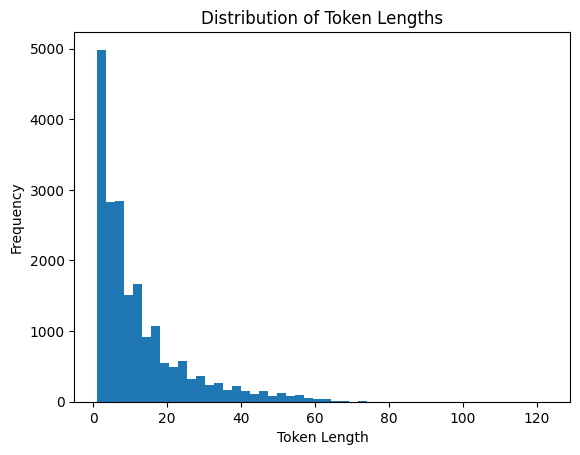

Maximum token length: 123


In [ ]:
# for finding max_length in dataset
import matplotlib.pyplot as plt

# Calculate the length of tokenized tweets
token_lengths = [len(tokenizer.tokenize(text)) for text in tweets_df['text']]

# Plot the distribution of token lengths
plt.hist(token_lengths, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

# Get the maximum token length
max_token_length = max(token_lengths)
print(f"Maximum token length: {max_token_length}")

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
FARZAN_TOKEN = "$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$"
model.push_to_hub("bert-fa-base-uncased-sentiment-nlp-hw2", use_auth_token=FARZAN_TOKEN)
tokenizer.push_to_hub("bert-fa-base-uncased-sentiment-nlp-hw2",  use_auth_token=FARZAN_TOKEN, commit_message="Upload Tokenizer")

In [47]:
from transformers import BertTokenizer, BertForSequenceClassification
model_name = "farzanrahmani/bert-fa-base-uncased-sentiment-nlp-hw2"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)  # 6 sentiment classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [53]:
# 2. find 10 nearest words from "آزادی" (using bert word embeddings)
word_embeddings = model.bert.embeddings.word_embeddings

embedding_dict = {word: word_embeddings(torch.tensor([tokenizer.convert_tokens_to_ids(word)]).to(device)).cpu().squeeze(0).detach().numpy() \
                  for word in tokenizer.get_vocab().keys()}
# embedding_dict.keys()
print(embedding_dict["ازادی"].shape)

(768,)


In [49]:
word = "ازادی"
nearest_words = find_k_nearest_neighbors(word, embedding_dict, 10)

print("10 Nearest Words from 'ازادی':")
for word in nearest_words:
    print(word)

10 Nearest Words from 'ازادی':
ازادسازی
ازاد
ازادیهای
ازادى
ازادیها
رهایی
ازادانه
اسایش
ازادشدن
تختی


In [19]:
# 2. Find 10 nearest words from "آزادی" (using last_hidden_state after encoding)
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd

# Load model and tokenizer
# model_name = "farzanrahmani/bert-fa-base-uncased-sentiment-nlp-hw2"
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name)  # Assuming the model is already loaded

# Load data from dataframe
SOURCE_DIR = '/content/gdrive/MyDrive/Q3_data.csv'
tweets_df = pd.read_csv(SOURCE_DIR)
tweets_df = tweets_df.rename(columns={'Text': 'text', 'Sentiment': 'label'})
tweets_df['text'] = tweets_df['PureText']  # Assuming you want to use PureText column
tweets_df = tweets_df.drop(['Unnamed: 0', 'Datetime', 'PureText', 'Language', 'Date'], axis=1)
label_mapping = {'very negative': 0, 'negative': 1, 'no sentiment expressed': 2, 'positive': 3, 'very positive': 4, 'mixed': 5}
tweets_df['label'] = tweets_df['label'].map(label_mapping)

# Get unique words from the 'text' column of the dataframe
unique_words = set()
for text in tweets_df['text']:
    unique_words.update(text.split())

# Remove single-character and ASCII words
unique_words = [word for word in unique_words if not word.isascii() and len(word) > 1]

# Find 10 nearest words from "آزادی"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Tokenize and encode "آزادی"
freedom_input = tokenizer.encode("آزادی", return_tensors="pt").to(device)
# freedom_output = model.bert(freedom_input).last_hidden_state.squeeze()[0,:]
# freedom_output = model.bert(freedom_input).last_hidden_state.squeeze()[-1,:]
freedom_output = model.bert(freedom_input).last_hidden_state.squeeze().mean(dim=0)

# Calculate cosine similarity between "آزادی" and all other words
word_embeddings = {}
# for word in unique_words: # out of memory
for word in unique_words[:2000]: # Limit to the first 2000 words to avoid memory issues
    input_ids = tokenizer.encode(word, return_tensors="pt").to(device)
    # output = model.bert(input_ids).last_hidden_state.squeeze()[0,:]
    # output = model.bert(input_ids).last_hidden_state.squeeze()[-1,:]
    output = model.bert(input_ids).last_hidden_state.squeeze().mean(dim=0)
    word_embeddings[word] = output

similarity_scores = []
for word, embedding in word_embeddings.items():
    similarity = F.cosine_similarity(freedom_output, embedding, dim=0).item()
    similarity_scores.append((word, similarity))

# Sort the similarity scores
sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
nearest_words = [word for word, _ in sorted_scores[:10]]  # Get the 10 nearest words

# print(f"10 nearest words to 'آزادی' using contextualized embeddings: {nearest_words}")
print(f"10 nearest words to 'آزادی' using contextualized embeddings:")
for word in nearest_words:
    print(word)

10 nearest words to 'آزادی' using contextualized embeddings:
آزادی‌ای
اسارت
آزادسازی
زندان
تبعیض
برابری
پیشرفت
نشینِ
نشین
پیمایی


##### Describe advantages and disadvantages of Contextualized embedding

Advantages: Contextualized embeddings capture the meaning of words in context, allowing for more nuanced representations. Models like BERT can handle polysemy and capture word meaning based on the surrounding context.
- Contextualized embeddings can capture the meaning of a word based on its context, handling polysemy effectively.
- They can be fine-tuned or adapted to specific tasks or domains, improving performance.
- They can capture complex linguistic relationships and dependencies.
- Context-Sensitive: They provide dynamic word representations based on context, leading to a more nuanced understanding of language.
- State-of-the-Art Performance: Excel in a wide range of NLP tasks, offering superior performance compared to previous models.


Disadvantages: Contextualized embeddings may require more computational resources compared to static embeddings like Word2Vec. They may also suffer from a lack of interpretability since the same word can have different embeddings depending on its context.
- Contextualized embeddings require more computational resources and larger models compared to static embeddings.
- They may not perform as well on tasks with limited training data or low resources.
- They can be more difficult to interpret and analyze compared to static embeddings.
- Computational Requirements: Demand extensive computational power and larger datasets for training.
- Complexity in Implementation: More complex to implement and integrate into applications compared to simpler models like TF-IDF.

In [ ]:
freedom_input = tokenizer.encode("آزادی", return_tensors="pt").to(device)
freedom_output = model.bert(freedom_input)  # Extract the contextualized embedding
# freedom_output = model.bert(freedom_input)[0][:, 0]  # Extract the first token's embedding
freedom_output.last_hidden_state

tensor([[[-0.8083, -1.9882, -0.1767,  ..., -0.5387, -0.7034,  0.6088],
         [-0.6252, -1.1439,  0.1460,  ...,  0.3552, -0.6754, -0.0487],
         [-0.1068, -1.3384,  0.6857,  ..., -0.4613,  0.2435,  0.7179]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
freedom_input = tokenizer.encode("فایتینگگگگگ", return_tensors="pt").to(device)
freedom_output = model.bert(freedom_input)  # Extract the contextualized embedding
freedom_output.last_hidden_state.size() #torch.Size([1, 8, 768]) # for "آزادی" --> [1, 3, 768]
freedom_output[0].squeeze().size() # torch.Size([3, 768])
# freedom_output.last_hidden_state.squeeze().mean(dim=0).size() [768]
freedom_output.last_hidden_state.squeeze()[0,:].size() # [768]
freedom_output.last_hidden_state.squeeze()[-1,:].size() # [768]

torch.Size([1, 8, 768])